In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

In [18]:
# Define the original ODE loss with initial condition
def original_loss(model, x):
    x = x.requires_grad_(True)  # Enable gradients for x
    y = model(x)
    dydx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]

    # Original ODE
    residual = dydx + y - (2 * np.pi * torch.cos(2 * np.pi * x) +
                           10 * np.pi * torch.cos(10 * np.pi * x) +
                           torch.sin(2 * np.pi * x) +
                           torch.sin(10 * np.pi * x))

    # Enforce the initial condition y(0) = 0
    ic_loss = (model(torch.tensor([[0.0]])) - 0) ** 2
    return torch.mean(residual**2) + ic_loss

In [19]:
# Define the scaled ODE loss with initial condition
def scaled_loss(model, xi):
    xi = xi.requires_grad_(True)  # Enable gradients for xi
    eta = model(xi)
    detadx = torch.autograd.grad(eta, xi, torch.ones_like(eta), create_graph=True)[0]

    # Scaled ODE
    residual = 2 * np.pi * detadx + eta - (2 * torch.cos(xi) +
                                           10 * torch.cos(5 * xi) +
                                           1 / np.pi * (torch.sin(xi) + torch.sin(5 * xi)))

    # Enforce the initial condition eta(0) = 0
    ic_loss = (model(torch.tensor([[0.0]])) - 0) ** 2
    return torch.mean(residual**2) + ic_loss

In [20]:
# Training function
def train_pinn(model, loss_fn, x, optimizer, epochs):
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return loss_history

In [21]:
# Define parameters and training data
x = torch.linspace(0, 1, 100).view(-1, 1)  # Domain for original ODE
xi = 2 * np.pi * x                        # Domain for scaled ODE

In [22]:
# Models
model_original = PINN()
model_scaled = PINN()

In [23]:
# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01)
optimizer_scaled = torch.optim.Adam(model_scaled.parameters(), lr=0.01)

In [24]:
# Training
epochs = 5000
print("Training the original PINN...")
loss_history_original = train_pinn(model_original, original_loss, x, optimizer_original, epochs)

Training the original PINN...
Epoch 0: Loss = 523.5178833007812
Epoch 500: Loss = 0.369682639837265
Epoch 1000: Loss = 0.12241903692483902
Epoch 1500: Loss = 0.15362735092639923
Epoch 2000: Loss = 0.08941192924976349
Epoch 2500: Loss = 0.034557171165943146
Epoch 3000: Loss = 0.02778075821697712
Epoch 3500: Loss = 0.08237958699464798
Epoch 4000: Loss = 0.016229230910539627
Epoch 4500: Loss = 0.013197212480008602


In [25]:
print("Training the scaled PINN...")
loss_history_scaled = train_pinn(model_scaled, scaled_loss, xi, optimizer_scaled, epochs)

Training the scaled PINN...
Epoch 0: Loss = 53.3914794921875
Epoch 500: Loss = 0.003846609964966774
Epoch 1000: Loss = 0.0018816182855516672
Epoch 1500: Loss = 0.020070457831025124
Epoch 2000: Loss = 0.04606568440794945
Epoch 2500: Loss = 0.001681310124695301
Epoch 3000: Loss = 0.0012075674021616578
Epoch 3500: Loss = 0.0012944041518494487
Epoch 4000: Loss = 0.0014600252034142613
Epoch 4500: Loss = 0.0016454182332381606


In [26]:
# Evaluate the models
x_eval = torch.linspace(0, 1, 100).view(-1, 1)
xi_eval = 2 * np.pi * x_eval
y_pred_original = model_original(x_eval).detach().numpy()
eta_pred_scaled = model_scaled(xi_eval).detach().numpy()
y_pred_scaled = np.pi * eta_pred_scaled  # Rescale scaled result to original domain

In [27]:
# Exact solution (not derived here but assumed known for comparison)
def exact_solution(x):
    return (
        (np.sin(2 * np.pi * x) + np.sin(10 * np.pi * x))
    )

In [28]:
x_exact = x_eval.numpy()
y_exact = exact_solution(x_exact)

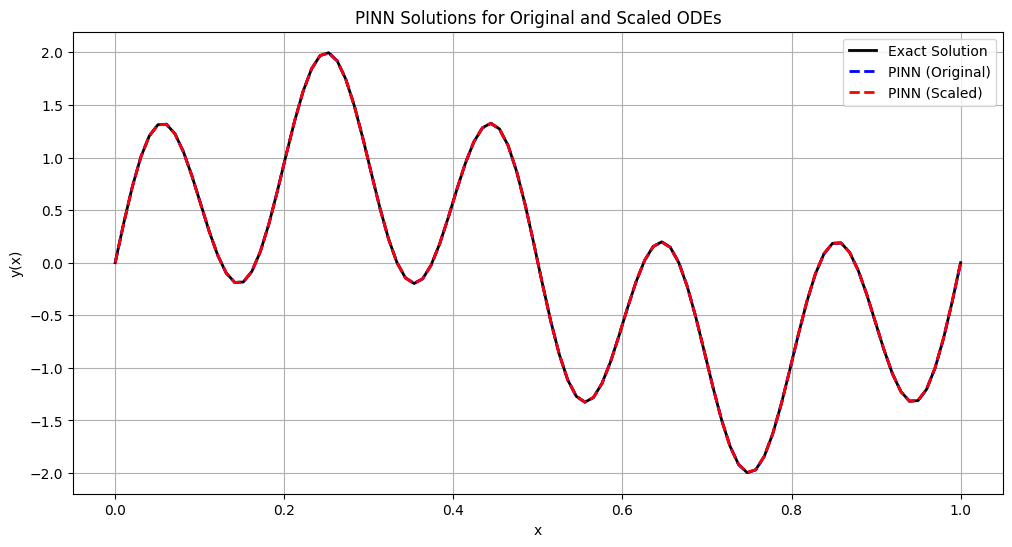

In [29]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_exact, y_exact, 'k-', label='Exact Solution', linewidth=2)
plt.plot(x_exact, y_pred_original, 'b--', label='PINN (Original)', linewidth=2)
plt.plot(x_exact, y_pred_scaled, 'r--', label='PINN (Scaled)', linewidth=2)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('PINN Solutions for Original and Scaled ODEs')
plt.legend()
plt.grid()
plt.show()

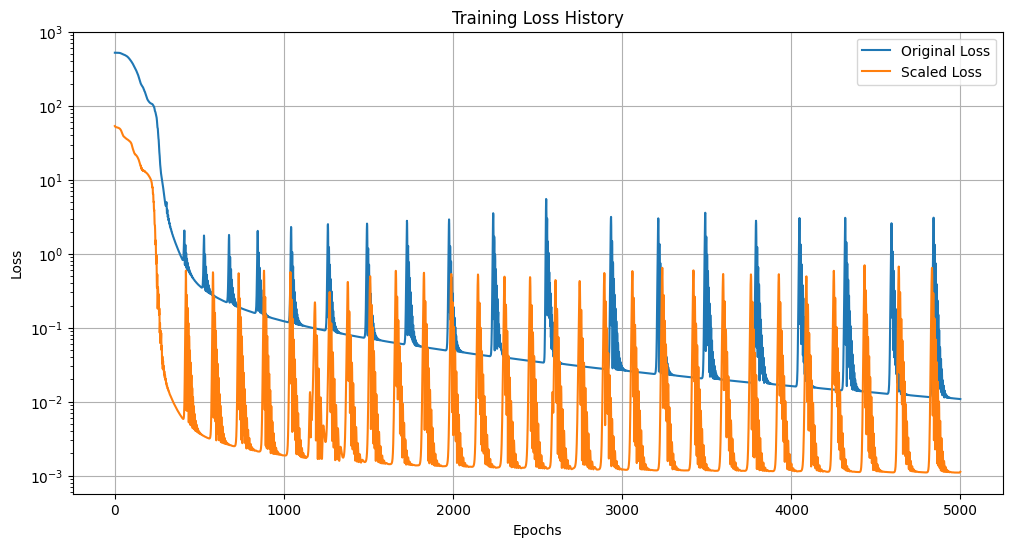

In [30]:
# Plot training loss histories
plt.figure(figsize=(12, 6))
plt.plot(loss_history_original, label='Original Loss')
plt.plot(loss_history_scaled, label='Scaled Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid()
plt.show()